# Build HDF5 Container Input for GCN from Methylation Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import gridspec
plt.rc('font', family='Times New Roman')
import h5py
import seaborn as sns
import os, sys

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Parameters
* `USE_BATCH_CORRECTED`: Whether or not to use the [batch corrected data](https://bioconductor.org/packages/release/bioc/vignettes/sva/inst/doc/sva.pdf) or not
* `USE_FOLDCHANGES`: Compute log fold changes between tumor and normal or simply subtract the normal methylation from the cancer case. The latter does not result in a significant change between 2% and 4% methylation (both basically None) while the fold changes would significantly change that.

In [4]:
USE_BATCH_CORRECTED = True
USE_FOLDCHANGES = False

## 1. Load Methylation Matrices & Compute Fold Changes

In [6]:
def get_ratio(tumor_sample_path, normal_sample_path, use_foldchange=False):
    tumor_samples = pd.read_csv(tumor_sample_path, sep='\t')
    normal_samples = pd.read_csv(normal_sample_path, sep='\t')

    # restore the column names for samples
    tumor_samples.columns = ['-'.join(i.split('.')[:7]) + '|' + i.split('.')[7] + '|' + i.split('.')[8] for i in tumor_samples.columns]
    normal_samples.columns = ['-'.join(i.split('.')[:7]) + '|' + i.split('.')[7] + '|' + i.split('.')[8] for i in normal_samples.columns]

    # make it the same genes for both dataframes and verify
    common_genes = tumor_samples.index.intersection(normal_samples.index)
    tumor_samples = tumor_samples.reindex(common_genes)
    normal_samples = normal_samples.reindex(common_genes)
    assert ((normal_samples.index == tumor_samples.index).all())

    if use_foldchange:
        # compute log2 fold changes (for each sample, divide by mean normal values. Then compute mean across samples)
        fc = np.log2(tumor_samples.divide(normal_samples.mean(axis=1), axis=0))
        fc_nan = fc.replace([np.inf, -np.inf], np.nan)
        print ("Got {} invalid values after computing log2 fold changes".format(fc_nan.isnull().sum().sum()))
        ratio = fc_nan.dropna(axis=0) # remove NaN and inf (from division by 0 or 0+eta)
    else:
        # subtract the ratios from one another
        ratio = tumor_samples.subtract(normal_samples.mean(axis=1), axis=0)
        ratio_nan = ratio.replace([np.inf, -np.inf], np.nan)
        print ("Got {} invalid values after subtraction".format(ratio_nan.isnull().sum().sum()))
        ratio = ratio_nan.dropna(axis=0)

    return ratio

base_dir = '../../data/pancancer/TCGA/methylation/gene_sample_matrices_cancertype/'

if USE_BATCH_CORRECTED:
    fname = '{}_samples.adjusted.tsv'
else:
    fname = '{}_samples.tsv'

all_ratios = []
for ctype in os.listdir(base_dir):
    ctype_dir = os.path.join(base_dir, ctype)
    if os.path.isdir(ctype_dir) and not ctype == 'OV': # don't have normals for OV
        ratio = get_ratio(os.path.join(ctype_dir, fname.format('tumor')),
                          os.path.join(ctype_dir, fname.format('normal')),
                          use_foldchange=USE_FOLDCHANGES
                         )
        all_ratios.append(ratio)
        print ("Processed {}".format(ctype))

Got 0 invalid values after subtraction
Processed UCEC
Got 0 invalid values after subtraction
Processed HNSC
Got 0 invalid values after subtraction
Processed LUAD
Got 0 invalid values after subtraction
Processed KIRP
Got 0 invalid values after subtraction
Processed KIRC
Got 0 invalid values after subtraction
Processed PRAD
Got 0 invalid values after subtraction
Processed COAD
Got 0 invalid values after subtraction
Processed GBM
Got 0 invalid values after subtraction
Processed LUSC
Got 0 invalid values after subtraction
Processed CESC
Got 0 invalid values after subtraction
Processed SARC
Got 0 invalid values after subtraction
Processed STAD
Got 0 invalid values after subtraction
Processed BRCA
Got 0 invalid values after subtraction
Processed BLCA
Got 0 invalid values after subtraction
Processed THCA
Got 0 invalid values after subtraction
Processed LIHC
Got 0 invalid values after subtraction
Processed SKCM
Got 0 invalid values after subtraction
Processed READ
Got 0 invalid values after su

In [7]:
meth_all_samples = all_ratios[0].join(all_ratios[1:]).dropna(axis=0)
meth_all_samples.head()

,TCGA-2E-A9G8-01A-11D-A409-05|ucec|mean_beta_value_promoter,TCGA-FI-A2D5-01A-11D-A17F-05|ucec|mean_beta_value_promoter,TCGA-EY-A1G8-01A-11D-A13K-05|ucec|mean_beta_value_promoter,TCGA-AX-A1CR-01A-12D-A138-05|ucec|mean_beta_value_promoter,TCGA-AJ-A6NU-01A-11D-A34S-05|ucec|mean_beta_value_promoter,TCGA-BG-A221-01A-21D-A161-05|ucec|mean_beta_value_promoter,TCGA-EY-A1GQ-01A-21D-A13K-05|ucec|mean_beta_value_promoter,TCGA-EY-A214-01A-12D-A161-05|ucec|mean_beta_value_promoter,TCGA-AX-A06D-01A-11D-A123-05|ucec|mean_beta_value_promoter,TCGA-D1-A102-01A-11D-A10N-05|ucec|mean_beta_value_promoter,...,TCGA-2J-AAB9-01A-11D-A40Y-05|paad|mean_beta_value_promoter,TCGA-FB-A4P6-01A-12D-A26Q-05|paad|mean_beta_value_promoter,TCGA-HV-A5A3-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-FB-AAPU-01A-31D-A40Y-05|paad|mean_beta_value_promoter,TCGA-IB-AAUT-01A-11D-A378-05|paad|mean_beta_value_promoter,TCGA-YH-A8SY-01A-11D-A378-05|paad|mean_beta_value_promoter,TCGA-2L-AAQE-01A-11D-A398-05|paad|mean_beta_value_promoter,TCGA-HV-A5A4-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-HZ-A4BK-01A-11D-A26Q-05|paad|mean_beta_value_promoter,TCGA-IB-7893-01A-11D-2202-05|paad|mean_beta_value_promoter
A1BG,-0.312389,-0.171679,-0.379949,0.117772,-0.139174,0.088733,-0.294148,-0.051125,0.204794,-0.263630,...,-0.017489,0.060618,0.068911,0.030062,-0.046013,-0.074703,0.052338,0.115983,-0.042469,-0.062298
A1BG-AS1,-0.037120,0.003336,-0.018939,-0.005204,0.187545,0.089367,0.209011,0.015204,-0.004317,-0.021179,...,0.016945,0.051033,0.151197,0.083424,-0.017829,0.071878,0.185689,0.286203,0.203245,0.014430
A2M,0.188502,0.177219,0.181447,0.239123,0.287604,0.255046,0.141191,0.220146,0.355261,0.149230,...,-0.092966,-0.067446,0.024820,0.005633,-0.086604,-0.161302,-0.155375,-0.197068,-0.110369,-0.275420
A2ML1,-0.339166,-0.305247,-0.350472,-0.384862,-0.070037,-0.028675,-0.303675,-0.094677,-0.146978,-0.265264,...,-0.080399,-0.013750,-0.415226,-0.303602,-0.033764,-0.269812,-0.271424,-0.060010,-0.123939,-0.167792
A4GNT,0.024405,-0.081893,0.091793,0.054119,-0.073537,-0.048233,-0.048488,-0.213277,0.036113,-0.147754,...,-0.066467,-0.119376,-0.074343,-0.251025,-0.060157,0.076133,-0.054540,-0.152842,-0.110846,0.066471


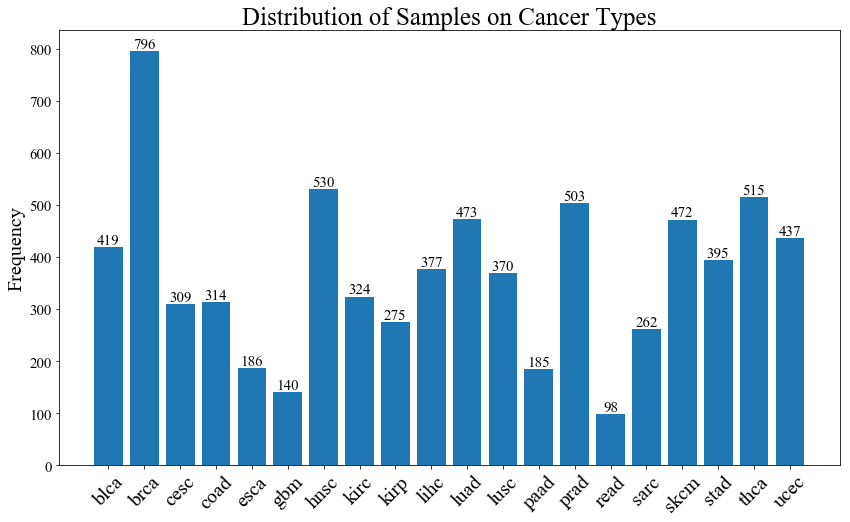

In [8]:
c_types = [n.split('|')[1] for n in meth_all_samples.columns[1:] if "mean_beta_value_promoter" in n]
unique, counts = np.unique(c_types, return_counts=True)
fig = plt.figure(figsize=(14, 8))
b = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=20)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Distribution of Samples on Cancer Types', fontsize=25)

# Add counts above the two bar graphs
for rect in b:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom', size=15)

fig.savefig('../../data/pancancer/TCGA/methylation/samples_per_cancertype.svg')

## 2. Mean Samples Across Cancer Types

In [9]:
# first, transpose and add column with cancer type
meth_t = meth_all_samples.T
meth_t['cancer_type'] = [i[1] for i in meth_t.index.str.split('|')]

# compute mean across all cancer types
meth_mean = meth_t.fillna(0).groupby('cancer_type').mean().T
meth_mean.head()

cancer_type,blca,brca,cesc,coad,esca,gbm,hnsc,kirc,kirp,lihc,luad,lusc,paad,prad,read,sarc,skcm,stad,thca,ucec
A1BG,-0.184742,0.012277,0.019589,-0.104712,0.005504,-0.015104,-0.040962,-0.005758,0.090671,-0.074419,0.022267,-0.014475,0.028326,-0.032416,-0.190746,-0.048976,0.006265,-0.141124,0.017843,-0.096495
A1BG-AS1,0.058487,0.003232,0.153094,0.169167,0.086243,0.026092,0.078595,0.015106,0.008506,0.091681,0.055800,0.027820,0.100264,0.044011,0.138566,-0.015453,-0.003352,0.139970,-0.007489,0.043973
A2M,0.041505,0.167203,0.383888,-0.064903,-0.109963,-0.428209,-0.133653,-0.098972,0.037711,0.011300,-0.017911,-0.023185,-0.141416,-0.119738,-0.120438,-0.020794,-0.216787,-0.171414,-0.017661,0.205473
A2ML1,-0.326522,-0.053121,-0.374979,-0.136581,-0.217341,-0.026535,-0.089906,-0.034573,0.011559,-0.240451,-0.090736,-0.294084,-0.136430,0.009241,-0.219687,0.070315,-0.012866,-0.144448,-0.018914,-0.163324
A4GNT,-0.214370,-0.132923,-0.239320,-0.172884,0.056125,-0.229338,-0.202726,-0.044552,-0.033644,-0.113087,-0.078952,-0.183460,-0.067271,-0.022335,-0.265251,-0.108456,0.007007,0.165865,-0.005549,-0.101590


/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


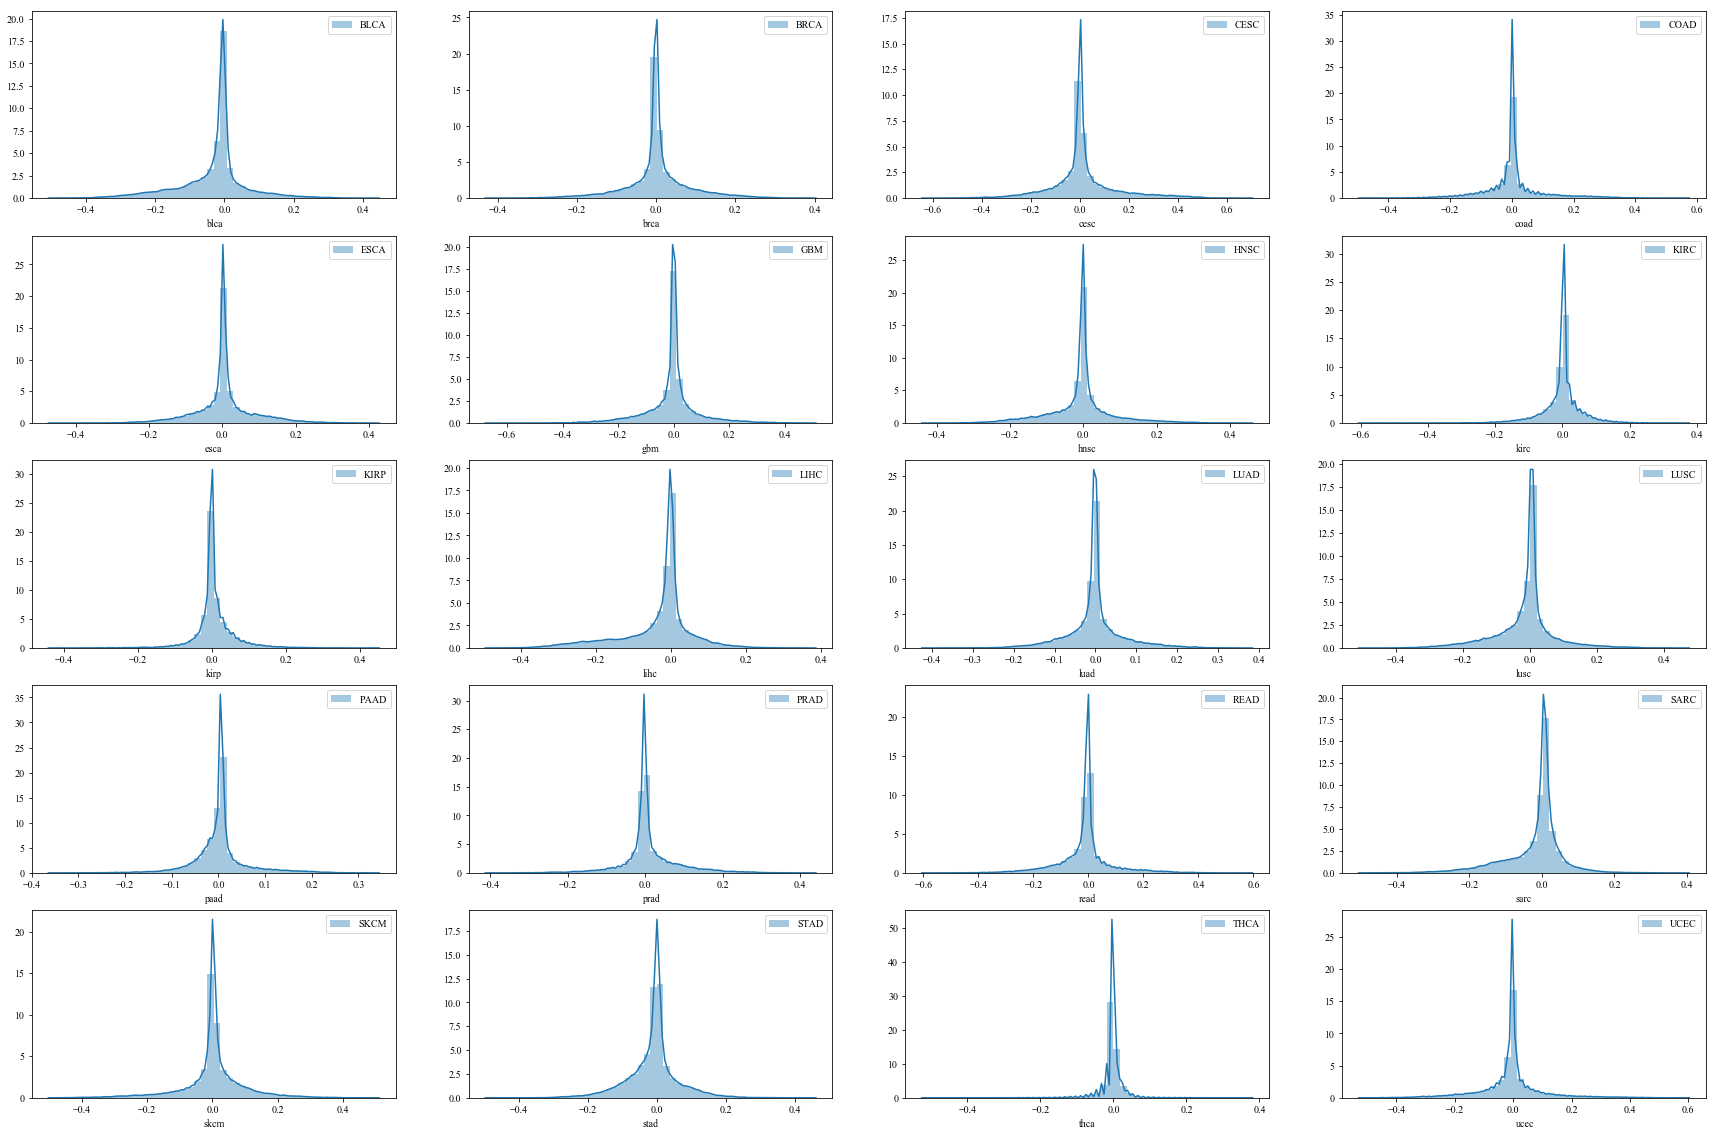

In [11]:
# convert to long format
fig = plt.figure(figsize=(30, 20))
count = 1
for col in meth_mean.columns:
    plt.subplot(5, 4, count)
    sns.distplot(meth_mean[col], label=col.upper(), hist=True)
    count += 1
    plt.legend()
    #plt.gca().set_xlim([-1, 1])
fig.savefig('../../data/pancancer/TCGA/methylation/distribution_{}_cancertypes.png'.format('FC' if USE_FOLDCHANGES else 'RATIO'), dpi=300)

## 3. Check Methylation for Oncogenes & Tumor Suppressors

Got 125 cancer genes
Other       26591
TSG            65
Oncogene       50
Name: type, dtype: int64


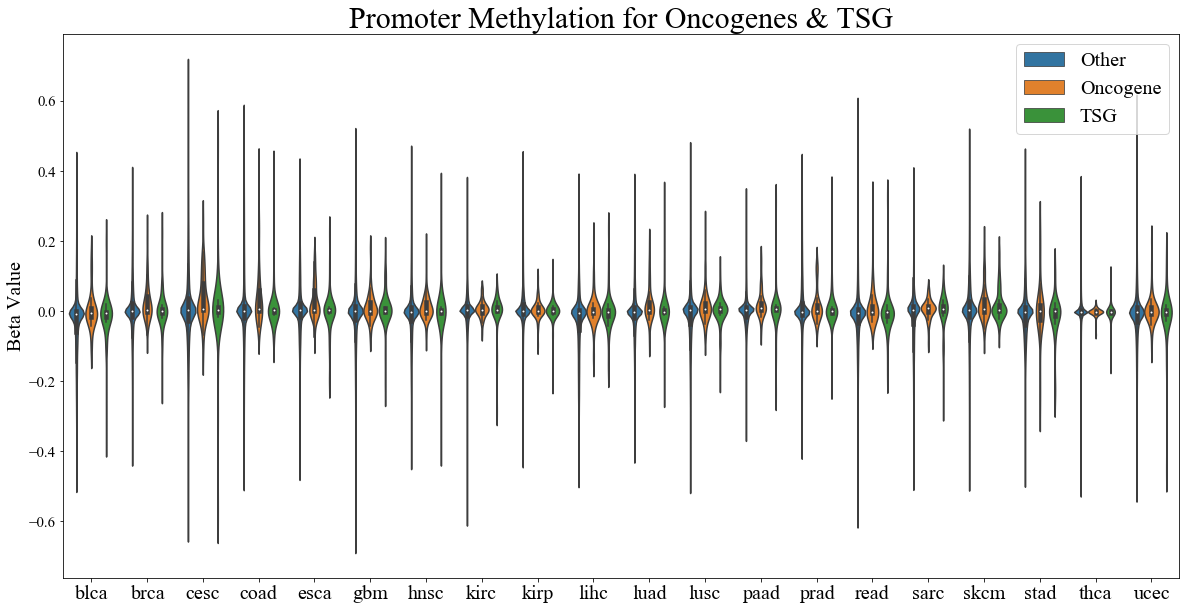

In [12]:
cancer_genes = pd.read_csv('../../data/pancancer/vogelstein/table_s2a.csv', sep='\t', header=0)
cancer_genes.columns = [i.strip('*') for i in cancer_genes.columns]
oncogenes = cancer_genes[cancer_genes.Classification == "Oncogene"]
suppressors = cancer_genes[cancer_genes.Classification == "TSG"]
print ("Got {} cancer genes".format(cancer_genes.shape[0]))

meth_mean_onco = meth_mean
meth_mean_onco.drop('kind', axis=1, inplace=True, errors='ignore')
meth_mean_onco['type'] = 'Other'
meth_mean_onco.loc[meth_mean_onco.index.isin(oncogenes['Gene Symbol']), 'type'] = 'Oncogene'
meth_mean_onco.loc[meth_mean_onco.index.isin(suppressors['Gene Symbol']), 'type'] = 'TSG'
print (meth_mean_onco.type.value_counts())

# plot
fig = plt.figure(figsize=(20, 10))
ax = sns.violinplot(data=pd.melt(meth_mean_onco, id_vars=['type']),
                        x='cancer_type',
                        y='value',
                        hue='type',
                        dodge=True,
                        scale_hue=True
                       )
plt.xlabel('')
plt.ylabel('Beta Value', fontsize=20)
plt.title('Promoter Methylation for Oncogenes & TSG', fontsize=30)
ax.tick_params(axis='x', which='major', labelsize=20)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.setp(ax.get_legend().get_texts(), fontsize='20')
plt.legend(loc='upper right', fontsize=20)
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.svg')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_promoter_methylation.png', dpi=300)

/home/sasse/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


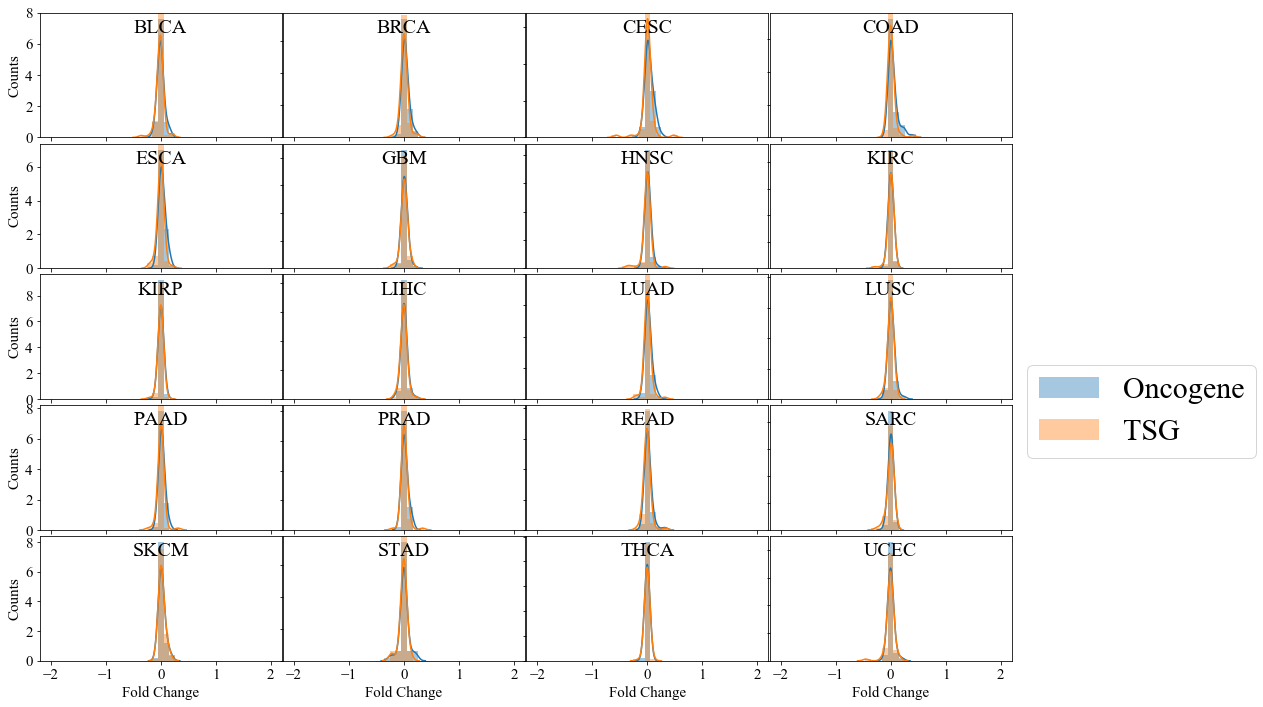

In [13]:
fig = plt.figure(figsize=(20, 10))

gs = gridspec.GridSpec(5, 4, width_ratios=[1, 1, 1, 1],
         wspace=0.005, hspace=0.05, top=0.95, bottom=0.05, left=0.17, right=0.845)

count = 1
bins = np.linspace(-2, 2, 40)
for ctype in meth_mean_onco.columns[:-1]:
    plt.subplot(gs[count-1])
    sns.distplot(a=meth_mean_onco.loc[meth_mean_onco.type == 'Oncogene', ctype],
                 label='Oncogene', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    sns.distplot(a=meth_mean_onco.loc[meth_mean_onco.type == 'TSG', ctype],
                 label='TSG', kde=True, bins=bins, hist_kws={'alpha':0.4}, kde_kws={'bw':0.05})
    #sns.kdeplot(data=meth_prom_mean.loc[meth_prom_mean.type == 'Other', ctype], label='Other', kde=True,
    #             hist_kws={"alpha": .1, "color": "g"}, kde_kws={'alpha':0.3}
    #            )
    plt.title(ctype.upper(), pad=-20, size=20)
    #plt.ylim([0, 1])
    #plt.xlim([-0.05, 1.05])
    if (count-1) % 4 == 0:
        plt.ylabel('Counts', fontsize=15)
        plt.setp(plt.gca().get_yticklabels(), size=15)
    else:
        plt.ylabel('')
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    if count in [17, 18, 19, 20]:
        plt.xlabel('Fold Change', fontsize=15)
        plt.setp(plt.gca().get_xticklabels(), size=15)
    else:
        plt.xlabel('')
        plt.setp(plt.gca().get_xticklabels(), visible=False)
        #plt.setp(plt.gca().get_yticklabels(), visible=False)
    count += 1
plt.legend(loc='center left', bbox_to_anchor=(1, 2), fontsize=30)
#plt.title('DNA Methylation Across Cancer Types', fontsize=30, loc='Center')
fig.savefig('../../data/pancancer/TCGA/methylation/oncogene_TSG_histograms.svg')

In [14]:
s = meth_mean.brca.idxmax()
meth_mean['mean_meth'] = meth_mean.drop('type', axis=1).mean(axis=1)
#meth_mean.sort_values(by='mean_meth', ascending=False).head(100)

## 4. Write methylation information to file
Finally, I want to write the methylation information to disk. I write a _csv_ file with the $Gene \times Ctype$ matrix containing the log2 fold changes per gene and cancer type.
Additionally, I also write the $Gene \times Sample$ matrix to hdf5.

In [15]:
meth_mean.to_csv('../../data/pancancer/TCGA/methylation/methylation_fc_mean.tsv', sep='\t')

In [16]:
meth_all_samples.to_hdf('../../data/pancancer/TCGA/methylation/sample_matrix_foldchanges.h5', 'methylation_sample_matrix', complevel=3)

In [ ]:
relevant_ctypes = ['BRCA', 'LUAD', 'UCEC', 'KIRC', 'HNSC', 'THCA', 'LUSC', 'PRAD', 'COAD', 'STAD', 'BLCA', 'LIHC', 'CESC', 'KIRP', 'ESCA', 'READ']
meth_mean.columns = [i.upper() for i in meth_mean.columns]
meth_mean = meth_mean[relevant_ctypes]
meth_mean.head()

,BRCA,LUAD,UCEC,KIRC,HNSC,THCA,LUSC,PRAD,COAD,STAD,BLCA,LIHC,CESC,KIRP,ESCA,READ
A1BG,0.012277,0.022267,-0.096495,-0.005758,-0.040962,0.017843,-0.014475,-0.032416,-0.104712,-0.141124,-0.184742,-0.074419,0.019589,0.090671,0.005504,-0.190746
A1BG-AS1,0.003232,0.055800,0.043973,0.015106,0.078595,-0.007489,0.027820,0.044011,0.169167,0.139970,0.058487,0.091681,0.153094,0.008506,0.086243,0.138566
A2M,0.167203,-0.017911,0.205473,-0.098972,-0.133653,-0.017661,-0.023185,-0.119738,-0.064903,-0.171414,0.041505,0.011300,0.383888,0.037711,-0.109963,-0.120438
A2ML1,-0.053121,-0.090736,-0.163324,-0.034573,-0.089906,-0.018914,-0.294084,0.009241,-0.136581,-0.144448,-0.326522,-0.240451,-0.374979,0.011559,-0.217341,-0.219687
A4GNT,-0.132923,-0.078952,-0.101590,-0.044552,-0.202726,-0.005549,-0.183460,-0.022335,-0.172884,0.165865,-0.214370,-0.113087,-0.239320,-0.033644,0.056125,-0.265251


## Compute Embedding of Methylation Samples

In [ ]:
meth_samplewise = meth_all_samples.dropna(axis=0).T
embedding = TSNE(n_components=2).fit_transform(meth_samplewise.drop(['cancer_type'], axis=1, errors='ignore'))

In [ ]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=meth_samplewise.index)
plate = [n.split('|')[0].split('-')[5] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
cancer_type = [n.split('|')[1] for n in meth_samplewise.index if "mean_beta_value_promoter" in n]
long['plate'] = plate
long['cancertype'] = cancer_type
g = sns.lmplot(x='pc1', y='pc2', data=long, hue='cancertype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=20, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of DNA methylation at Promoters for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/methylation/tsne_tumortypes.png', dpi=300)